# Ex 6: Spatial data analysis

**Background**

Geoscientific problems often involve both spatial and temporal data analysis. In this exercise, we will focus mainly on the former. Although such problems can be tackled in a Geographic Information System (GIS) software environment, when dealing with large data sets and/or computationally intensive analyses it is often better to perform the analyses directly though code in a programming language such as Python. 

We will concentrate on making use of spatial regression using statistical/machine learning models on sparse data to recounstruct snow mass over the Mammoth Lakes basin (MLB, around 37$^\circ$N, -119$^\circ$E), nested in the high Sierra Nevada in California, USA. In California, snow is a vital resource for hydropower, drinking water, agriculture, and tourism. Over the last decade several low snow years in the Sierras have excarbated problems related to water scarcity in the region. This helped spark the creation of the NASA Airborne Snow Observatory (ASO) to help improve snowpack monitoring in the mountains of the western USA. The ASO is a coupled lidar-spectrometer system that is flown on a propeller plane, allowing for the accurate retrieval of the spatial distribution of several snowpack variables at unprecedented accuracy and spatial resolution for entire mountain basins. 

Our target variable will be the snow water equivalent (SWE) depth (denoted $D$), measured in meters, which represents the depth of liquid water that would result if a snowpack was melted instantaneously. This is often the primary snow variable of interest for hydrologist, since it is represents a large natural water reservoir that can melt and runoff to feed streams and rivers. It can easily be converted to snow mass (per unit area) through multiplication with the density of fresh liquid water $\rho_w=10^3$ kg m$^{-3}$. For each ASO flight at our disposal, we will regress a sparse subset of the SWE data on static terrain and land cover parameters to try and impute (gap-fill) the SWE in unobserved locations.

**Regression**

In many modeling problems, including regression, we are often interested in learning a model $\mathcal{M}$ (with tuning parameters $\boldsymbol{\theta}$) that maps from some vector of inputs $\mathbf{x}$ to some scalar output $y$, i.e.

\begin{equation} y=\mathcal{M}(\mathbf{x},\boldsymbol{\theta}) \end{equation}

As you have learned, we typically split the data in two sets: a training set used to learn (fit) the regression model and a validation set used to validate the model. In this exercise this split will occur quite naturally given the nature of the problem.

When building your model, you are free to test out any regression technique that you like. This also means that you can use whichever module you like (e.g. `scikit-learn, scipy, PyTorch, Theano, Keras, TensorFlow`), with `scikit-learn` being a safe choice. Due to the no free lunch theorem, it is recommended that you experiment with different models such as: multiple linear regression, support vector machines, gaussian process regression, random forests, and neural networks. 

**Input**

All the input data we need is stored in the netcdf file `ASO_MLB.nc` as images/rasters with 100 m picture element (pixel) resolution covering the entire MLB. Such netcdf files are widely used in Earth system science since they are widely compatible, efficient for both input/output operations and storage, and can hold valuable metadata. Note that for image data the value of a variable for a specific pixel represents the spatial mean value across that pixel. The dataset includes the following variables: 
1. `D`: A 3D array containing 3 SWE images retrieved from the ASO around the same time (April-May) near the peak of the snow season (i.e. maximum SWE) during 2017, 2018, and 2019. This will be your target/output variable $y$.
2. Terrain parameters derived from the SRTM digital elevation model stored in the 2D arrays `z` (elevation),  `asp` (aspect), `slp` (slope), `svf` (sky view factor). These can be input variables/predictors for the regression (i.e. elements of $\mathbf{x}$).
3. Land cover parameters derived from the National Land Cover Database stored in the 2D arrays `cc` (canopy cover) and `mask` (basin and water mask). These can be input variables/predictors for the regression (i.e. elements of $\mathbf{x}$).
4. Coordinates of all the pixels in the images which are stored in the 2D arrays `X` (easting) and `Y` (northing). These can be input variables/predictors for the regression (i.e. elements of $\mathbf{x}$).

To read in and visualize the data, you may find the following example helpful:

In [184]:
from netCDF4 import Dataset
import numpy as np
import scipy.stats as st

ncf='ASO_MLB.nc' # Input file
fh=Dataset(ncf,mode='r') # Assign a file handel and open the file for reading
fh # Display an overview of the file contents

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: ASO Mammoth Lakes basin machine learning and geostatistics data set
    contains: SWE depth maps from 3 Airborne Snow Observatory lidar scans (near peak SWE for 2017-2019)  and "static" terrain parameters from the SRTM DEM and the National Land Cover Database
    location: Mammoth Lakes basin (around lat=37.6N,lon=-119E), in the Californian Sierra Nevada
    time period: Maximum SWE flights for 2017, 2018, and 2019
    georeferencing: Pixels/cells are regularly spaced in zone 11S of the UTM projection based on the WGS84 ellipsoid.
    convention: By convention, the first pixel (i.e.: row index i=1, column index j=1) is in the upper left corner of the image.
    dimensions: The image stack "D" (SWE maps) have 3 dimensions [dim1=rows=y_i=northing, dim2=columns=x_j=easting, dim3=t_n=time of flight]
    Ground sampling distance: GSD=100 meters (spatial resolution)
    easting coordinate: The eas

Towards the bottom of the output (row  `variables(dimensions)`) we recognize the input and output variables that were previously described. To learn more about a specific variable, such as the elevation `z`, try the following:

In [2]:
fh['z'] # Display information about variable  'z'

<class 'netCDF4._netCDF4.Variable'>
float64 z(x, y)
    _FillValue: nan
    long_name: Elevation [m a.s.l.] derived from the SRTM DEM
unlimited dimensions: 
current shape = (77, 83)
filling on

To read in and visualize images, you can adapt the following script

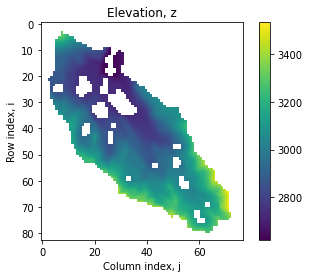

In [3]:
import matplotlib.pyplot as plt

z=fh.variables['z'] # Read in the elevation
# Transpose the array to get standard dimensions [rows: northing (y), columns: easting (x)]
z=np.transpose(np.array(z)) 
z=np.array(z)

plt.figure()
cm=plt.imshow(z)
plt.title('Elevation, z')
plt.ylabel('Row index, i')
plt.xlabel('Column index, j')
plt.colorbar()
plt.show()

As is the convention in image analysis, the image is indexed so that the pixel in the first row  and column (i.e. `[i=0,j=0]` in python) appears in in the upper left corner. Thereby, the `x` coordinate (not to be confused with the input/predictor $\textbf{x}$) increases as its index ($j$) increases and we move across the columns from west to east (left to right) in the image, while the `y` coordinate (not to be confused wiht the output/target $y$) decreases as its index ($i$) increases as we move down the rows from north to south (top to bottom) in the image.

### Question 1: Preparing and exploring the data

In this part you won't do any regression, instead you will perform the initial steps of preparing and exploring the dataset that you will later build regression models with. Although much of the time consuming pre-processing has already been completed for you through steps such as retrieving the data, homogenization (mapping to the same grid and resolution), and masking (you should ignore the pixels with `nan` values), the dataset is still not completely ready for regression "out of the box". 

To help get you started, mapping from a 2D image (with `nan` values) to a clean 1D array (no `nan` values) for regression, and then back to a 2D image can be done as follows using `svf` as an example


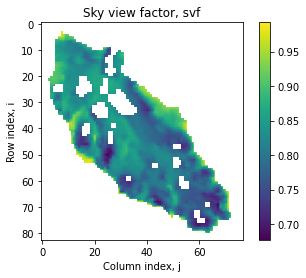

In [4]:
svf=fh.variables['svf']
svf=np.transpose(np.array(svf)) 
these=~np.isnan(svf) # A 2D Boolean array whose elements are true for the pixels that are not NaN. 
image=np.zeros_like(svf); # Image template array to map back to later.
svf_image=image
svf_clean=svf[these] # A 1D array that contains the non NaN points in svf. 
svf_image[these]=svf_clean; # Set to svf_clean for non NaN points.
svf_image[~these]=np.nan; # Set to NaN for remaining points.

plt.figure()
cm=plt.imshow(svf_image)
plt.title('Sky view factor, svf')
plt.ylabel('Row index, i')
plt.xlabel('Column index, j')
plt.colorbar()
plt.show()

Note that the boolean array `these` is the same for all the 2D images, since we are always using the same basin and water mask. That is to say, areas where `mask==False` have already been set to `nan` for all the variables as these areas are either outside the basin or water bodies.

**a)** Read in all the variables in `ASO_MLB.nc`. Clean (remove) the `nan` values. For each year, plot the SWE (`D`) histograms and calculate the mean and standard deviation. Briefly describe the distributions and the differences you see between the 3 years.

In [92]:
ncf='ASO_MLB.nc' # Input file
fh=Dataset(ncf,mode='r') # Assign a file handel and open the file for reading

#var=['z','asp','slp','svf','cc','X','Y','D']

mask=fh.variables['mask']
mask=np.transpose(np.array(mask))
these=mask==True

z=fh.variables['z']
z=np.transpose(np.array(z))
z_clean=z[these]

asp=fh.variables['asp']
asp=np.transpose(np.array(asp))
asp_clean=asp[these]

slp=fh.variables['slp']
slp=np.transpose(np.array(slp))
slp_clean=slp[these]

svf=fh.variables['svf']
svf=np.transpose(np.array(svf))
svf_clean=svf[these]

cc=fh.variables['cc']
cc=np.transpose(np.array(cc))
cc_clean=cc[these]

X=fh.variables['X']
X=np.transpose(np.array(X))
X_clean=X[these]

Y=fh.variables['Y']
Y=np.transpose(np.array(Y))
Y_clean=Y[these]

D=fh.variables['D']
D=np.transpose(np.array(D))
D_clean=D[these]

fh.close()

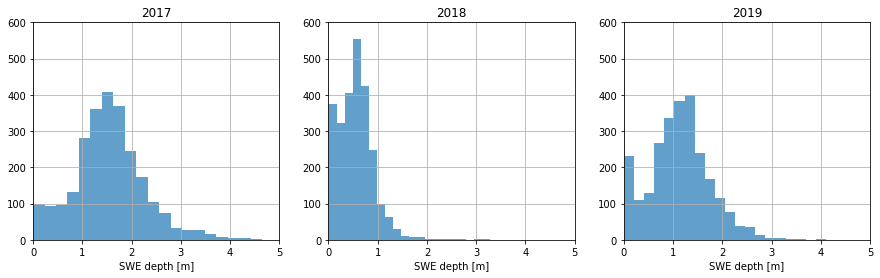

In [129]:
# Plot histogram of SWE-depth for 2017, 2018 and 2019

F=3 # Number of years

fig=plt.figure(figsize=(15,4))

for f in range(F):
    plt.subplot(int('13'+str(f+1)))
    plt.grid()
    plt.title(str(int('2017')+f))
    plt.hist(D_clean[:,f],bins=20,alpha=0.7)
    plt.xlim([0, 5])
    plt.ylim([0, 600])
    plt.xlabel('SWE depth [m]')


In [124]:
# Calculate mean and standard deviation for each year

for f in range(F):
    Dmean = np.mean(D_clean[:,f])
    Dstd = np.std(D_clean[:,f])
    print(str(int('2017')+f)+':')
    print('SWE depth mean: %g m.' %Dmean)
    print('SWE depth standard deviation: %g m.\n' %Dstd)

2017:
SWE depth mean: 1.54336 m.
SWE depth standard deviation: 0.72216 m.

2018:
SWE depth mean: 0.55404 m.
SWE depth standard deviation: 0.363263 m.

2019:
SWE depth mean: 1.13546 m.
SWE depth standard deviation: 0.613755 m.



When you are done reading in all the variables in the netcdf file it is good practice to close it for reading with the following command `fh.close()`. You should now have a bunch of clean 1D arrays containing the different input and output variables.

**b)** Generate scatter plots of the output/target `D` versus each of the the individual predictors (input variables) and calculate the sample (Pearson) correlation coefficients. Do this analysis seperately for each of the 3 ASO flights (water years). Comment briefly on the relationships that you see. [**Hint**: From the aspect `asp` it might help to generate two different predictors, namely: the "northness" `nness=-np.cos(asp)` and "eastness" `eness=np.sin(asp)`]

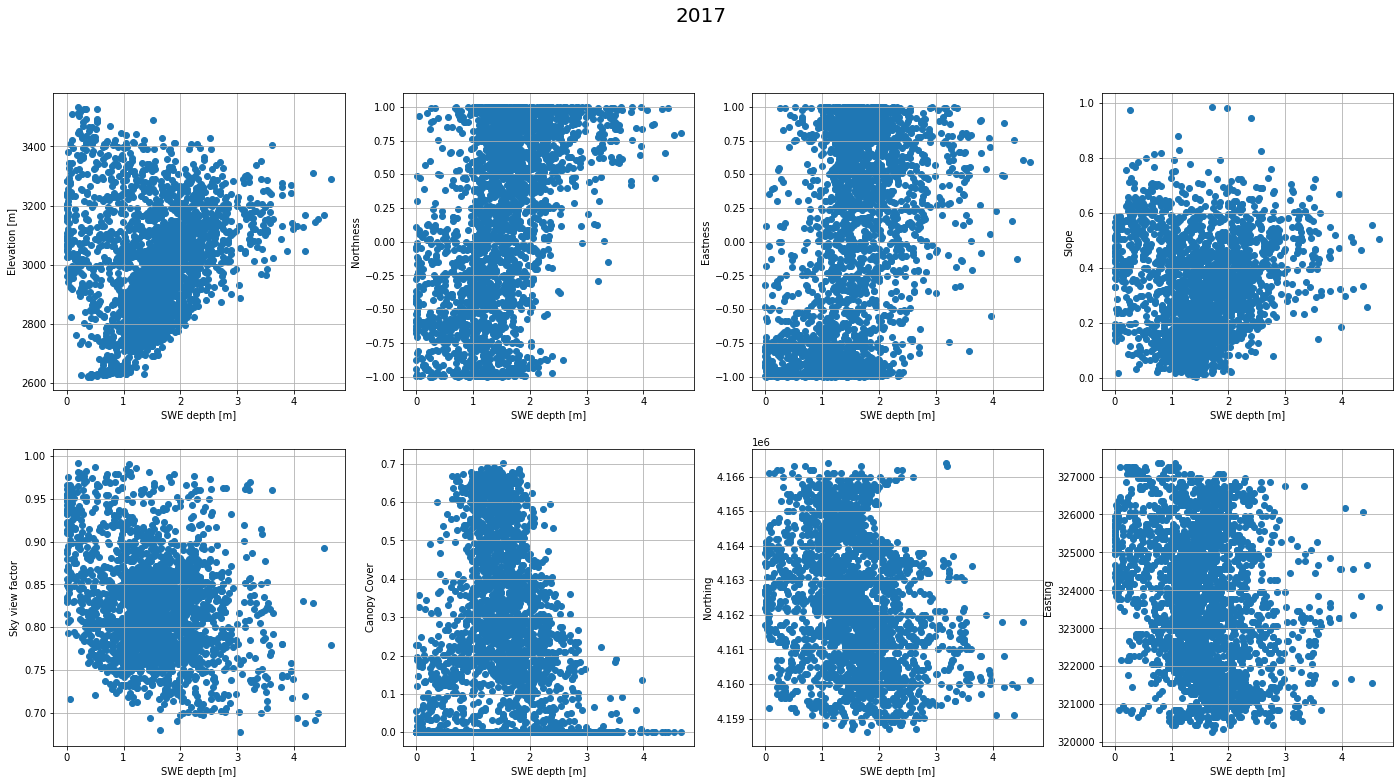

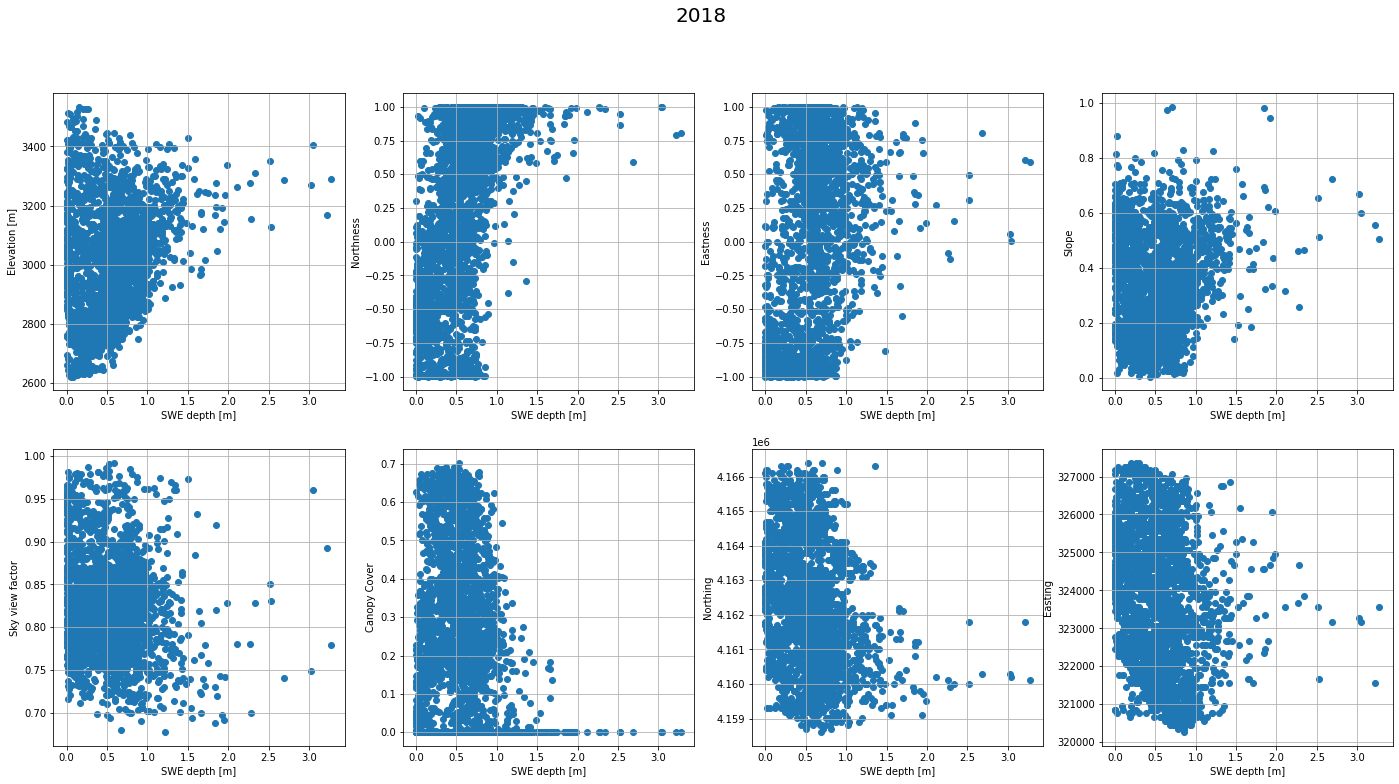

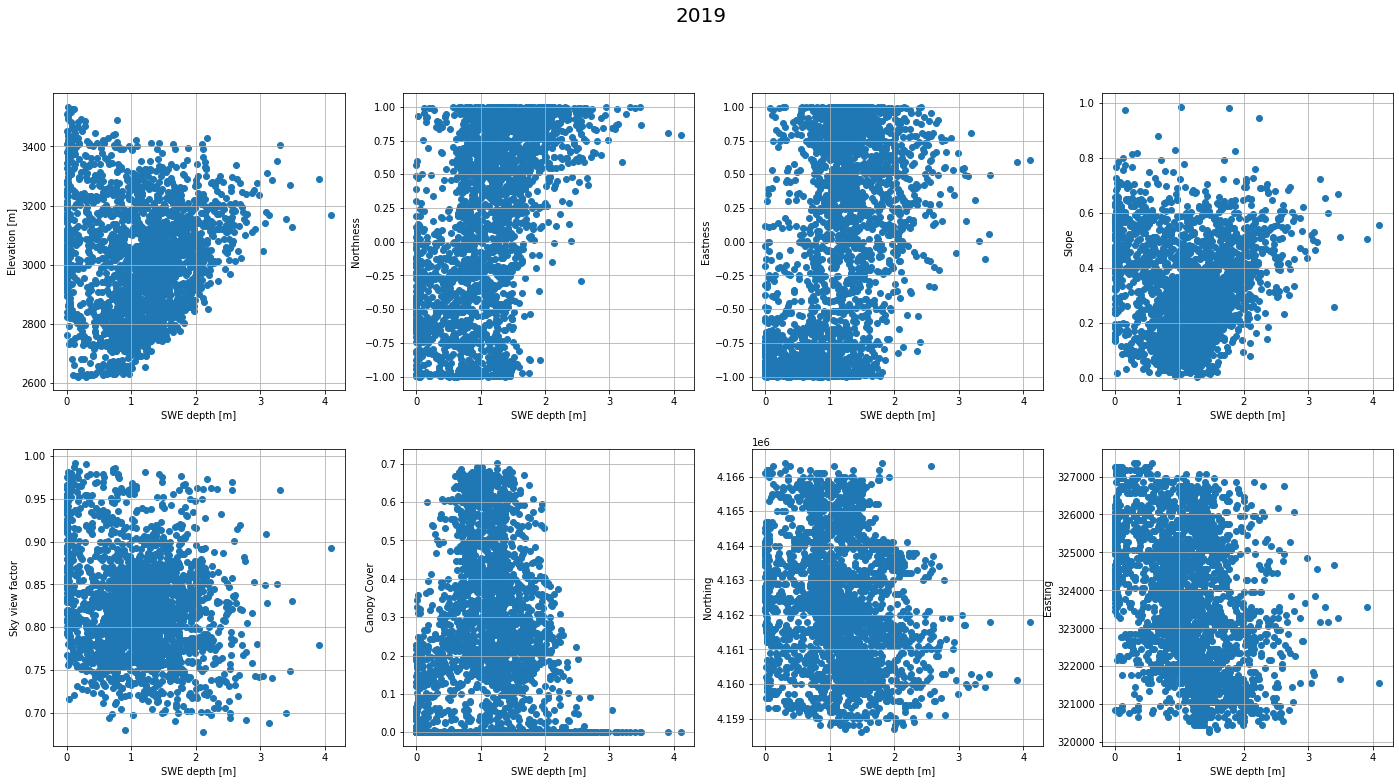

In [161]:
from scipy.stats import pearsonr

nness=-np.cos(asp_clean)
eness=np.sin(asp_clean)

for f in range(F):
    year=str(int('2017')+f) 
    fig=plt.figure(figsize=(24,12))
    plt.suptitle(year,fontsize=20)

    plt.subplot(241)
    plt.grid()
    plt.scatter(D_clean[:,f],z_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Elevation [m]')

    plt.subplot(242)
    plt.grid()
    plt.scatter(D_clean[:,f],nness)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Northness')

    plt.subplot(243)
    plt.grid()
    plt.scatter(D_clean[:,f],eness)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Eastness')

    plt.subplot(244)
    plt.grid()
    plt.scatter(D_clean[:,f],slp_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Slope')

    plt.subplot(245)
    plt.grid()
    plt.scatter(D_clean[:,f],svf_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Sky view factor')

    plt.subplot(246)
    plt.grid()
    plt.scatter(D_clean[:,f],cc_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Canopy Cover')

    plt.subplot(247)
    plt.grid()
    plt.scatter(D_clean[:,f],Y_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Northing')

    plt.subplot(248)
    plt.grid()
    plt.scatter(D_clean[:,f],X_clean)
    plt.xlabel('SWE depth [m]')
    plt.ylabel('Easting')
    
    plt.show

In [163]:
for f in range(F):
    year=str(int('2017')+f) 
    print('%s Pearson correlation coefficients for SWE depth:'%year)
    print('Elevation: %g' %pearsonr(D_clean[:,f],z_clean)[0])
    print('Northness: %g' %pearsonr(D_clean[:,f],nness)[0])
    print('Eastness: %g' %pearsonr(D_clean[:,f],eness)[0])
    print('Slope: %g' %pearsonr(D_clean[:,f],slp_clean)[0])
    print('Sky view factor: %g' %pearsonr(D_clean[:,f],svf_clean)[0])
    print('Canopy cover: %g' %pearsonr(D_clean[:,f],cc_clean)[0])
    print('Northing: %g' %pearsonr(D_clean[:,f],Y_clean)[0])
    print('Easting: %g\n' %pearsonr(D_clean[:,f],X_clean)[0])

2017 Pearson correlation coefficients for SWE depth:
Elevation: 0.167677
Northness: 0.489631
Eastness: 0.415912
Slope: 0.0990237
Sky view factor: -0.259273
Canopy cover: -0.147272
Northing: -0.26783
Easting: -0.251467

2018 Pearson correlation coefficients for SWE depth:
Elevation: 0.239882
Northness: 0.546196
Eastness: 0.375894
Slope: 0.127249
Sky view factor: -0.139149
Canopy cover: -0.155707
Northing: -0.299016
Easting: -0.241515

2019 Pearson correlation coefficients for SWE depth:
Elevation: 0.0944707
Northness: 0.497895
Eastness: 0.450348
Slope: 0.0491771
Sky view factor: -0.170183
Canopy cover: -0.0565202
Northing: -0.169474
Easting: -0.361424



Since California is quite sunny, it is relatively easy to identify pixels without any snow using optical satellite imagery, so we may remove these areas from our analysis since we can estimate their contribution to the basin-averaged SWE (or total snow mass) quite accurately. For this reason, and to simplify the analysis, we will only focus on the pixels that are snow covered (i.e. $D>0$) in all 3 of the ASO flights. 

**c)** How many pixels are snow covered in all the ASO flights and how does this compare to the number of snow covered pixel for each of the flights? What does this indicate about the potential of using only the number of snow covered pixels for estimating basin-average SWE in a given year?

In [164]:
snow17=D_clean[:,0]>0
snow18=D_clean[:,1]>0
snow19=D_clean[:,2]>0

snowall=snow17*snow18*snow19

D_snow=D_clean[snowall]

np.shape(D_snow)

(2523, 3)

Now that you have identified the pixels that are always snow covered, remove the remaining (i.e. snow free) pixels from your clean 1D arrays. You can use the binary (Boolean) array that you used to 2D images later.

### Question 2: Regression experiments

In the next questions, we will randomly distribute $K$ sparse ASO SWE meausurements across the basin for all the flights. These sparse measurements will represent accurate hypothetical in-situ SWE instruments that could be installed in the future, and we will call them "station measurements". We assume that these hypothetical measurements are well calibrated and represent the same scale as the ASO data (100 m pixels), so there is no need for redundancy (multiple measurements per pixel). Using these station measurements and the input/predictor values at those locations, you will train a regression model to estimate SWE at unobserved locations. So the station measurements (sparse ASO SWE measurements) will be your training data, while the remaining sparse SWE measurements in "unobserved" locations will serve as validation data. The overarching goal is to get a statistically significantly better estimate of the basin-averaged SWE from the regresion than just using the sample mean from the stations. 

For the next question (***a)***), you may find Sterling's approximation for factorials of large integers $n$:
\begin{equation} n! \simeq n\ln(n)-n \end{equation}
quite helpful when you are working out the combinatorics.

**a)** Given that you have $K=100$ identical new in-situ instruments, how many different ways (order does not matter) could you distribute these across the $N$ pixels you are considering ($N$ is the answer to ***1c)***)? Would it be feasible to try regression experiments for all these combinations?

In [10]:
from scipy.special import comb
comb(2523, 100, exact=False, repetition=False)

2.2815504783355124e+181

In terms of water resources, you are primarily interested in being able to accurately estimate the basin-averaged SWE. To evaluate the performance of your regressions, it is useful to compare two different errors. The first we will call the station error, defined as
 \begin{equation} \epsilon_s = |\bar{y} - \mu| \end{equation}
 This represents the absolute bias of the mean SWE estimate obtained from the sample mean of the $K$ station measurements  ($\overline{y}$) relative to the true mean SWE over all the $N$ pixels ($\mu$). The second type of error is the regression error, which we will define as
 \begin{equation} \epsilon_r = |<\hat{y}>-\mu| \end{equation} 
 This represents the absolute bias of the mean SWE estimate obtained from the sample mean of the regression estimates ($\hat{y}$) over all the $N$ pixels ($<\hat{y}>$) relative to the true mean. We will consider these errors individually for each flight. Our aim is to have a lower regression error than station error across the three flights, and we may quantify this through
 \begin{equation} \delta = \frac{1}{F}\sum_{f=1}^F (\epsilon_r^{(f)}-\epsilon_s^{(f)})\end{equation}
 where $f$ indexes the flights and $F=3$ is the number of flights, where $\delta<0$ indicates an improvement thanks to regression and we would like to achieve a statistically significant improvement when doing this experiment many times (i.e. with many different random station measurement distribution).

***b)*** Show that $\epsilon_r$ is formally equal to the absolute regression bias defined as \begin{equation} \epsilon_r = |\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)| \end{equation}

***c)*** Set up an experiment so that you can train regression algorihtms on $K$ randomly selected pixels (without repetition) out of the $N$ pixels available. The training should be done independently for each of the $3$ ASO flights (2017-2019), although the same pixels should be used for training each flight. Continue refining and tuning your algorithm until you are able to achieve an improvement thanks to regression (i.e. $\delta<0$). Briefly describe which algorithms you tried  (try at least 4) and what you ended up with using. [Hint: Define two arrays `y_train` (dimension: $K$) and `X_train` (dimension: $K$ by $P$) where $P$ is the number of predictors you are condisering, and use these to train a regression algorithm and use this for prediction]

In [176]:
N = np.size(D_snow[:,0])
K = 100
predictors = np.array([z_clean[snowall], svf_clean[snowall]])
P = len(predictors)

training = np.random.choice(N,K,replace=False)

y_train = np.zeros((K,F))
X_train = np.zeros((K,P))

for f in range(F):
    y_train[:,f] = D_snow[:,f][training]
for i in range(P):
    X_train[:,i] = predictors[i][training]    

In [169]:
from sklearn.ensemble import RandomForestRegressor
regr=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)

ypred=np.zeros((N,F))
for f in range(F):
    regr.fit(X_train[:,:,f],y_train[:,f])
    ypred[:,f]=regr.predict(np.transpose(predictors))

<ipython-input-170-618536e1848b>:9: RuntimeWarning: divide by zero encountered in log10
  cm=plt.imshow(np.log10(np.abs(D_emulate-D[:,:,f])))


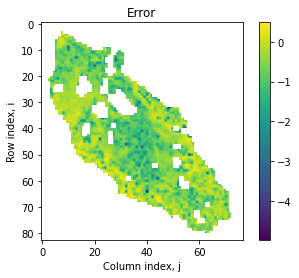

In [170]:
f=0
D_emulate=np.zeros_like(D[:,:,f])
ypred_withzeros=np.zeros_like(D_clean[:,f])
ypred_withzeros[snowall] = ypred[:,f]
D_emulate[these]=ypred_withzeros
D_emulate[~these]=np.nan

plt.figure()
cm=plt.imshow(np.log10(np.abs(D_emulate-D[:,:,f])))
plt.title('Error')
plt.ylabel('Row index, i')
plt.xlabel('Column index, j')
plt.colorbar()
plt.show()

In [171]:
f=0
mu = np.mean(D_snow[:,f])
ybar = np.mean(y_train[:,f])
e_s = abs(ybar - mu)
e_r = 0
for i in range(N):
    e_r += ypred[i,f] - D_snow[i,f]
e_r = abs(e_r/N)
delta = e_r - e_s
delta

-0.023440293066983385

***d)*** To help support the fact that the results from ***2c)*** were not a fluke, wrap an outer loop around your the experiment so that you can perform $L=200$ independent experiments (each with a different selection of the $K$ training pixels) where you store $\delta$ for each trial. Continue refining your choice of algorithm until your samples of $\delta$ are statistically significantly different from $0$ according to the criterion $p<0.05$ using a left-tailed Student's t-test. Briefly explain (i) what is meant by statistical significance and (ii) why we are using a left-tailed test.

In [216]:
N = np.size(D_snow[:,0])
K = 100
predictors = np.array([z_clean[snowall], svf_clean[snowall]])
P = len(predictors)
L = 200
F=3

y_train=np.zeros((K,F))
X_train=np.zeros((K,P))
y_pred=np.zeros((N,F))
delta=np.zeros(L)
e_s=np.zeros(F)
e_r=np.zeros(F)

# Yearly true means
mu=np.zeros(F)
for f in range(F):
    mu[f]=np.mean(D_snow[:,f])


for l in range(L):
    training=np.random.choice(N,K,replace=False)
    
    for p in range(P):
        X_train[:,p]=predictors[p][training]
    
    for f in range(F):
        y_train[:,f]=D_snow[:,f][training]

        regr.fit(X_train,y_train[:,f])
        y_pred[:,f]=regr.predict(np.transpose(predictors))

        ybar=np.mean(y_train[:,f])
        e_s[f]=abs(ybar-mu[f])
        e_r[f]=abs(np.sum(y_pred[:,f]-D_snow[:,f])/N)
    
    delta[l]=np.sum(e_r-e_s)/F

In [206]:
np.shape(np.transpose(predictors))

(2523, 5)

In [217]:
print(np.mean(delta))
np.std(delta)

-0.0013712834333586927


0.026229497855803953

In [218]:
mu_0 = 0
alfa = 0.05
T = (np.mean(delta) - mu_0)/(np.std(delta)/np.sqrt(L))
t = st.t.ppf(alfa,L-1)
print(T)
print(t)

-0.7393537001640649
-1.6525467461659398


***e)*** Visualize the regression results for the configuration (station measurement locations and algorithm choice) where you got the largest improvement (lowest $\delta$) in the $L$ trials above by plotting images of the regression results next to the truth (ASO data) using the same range for your colormap scale as well as scatter plots of regression estimate versus truth value for each flight. 

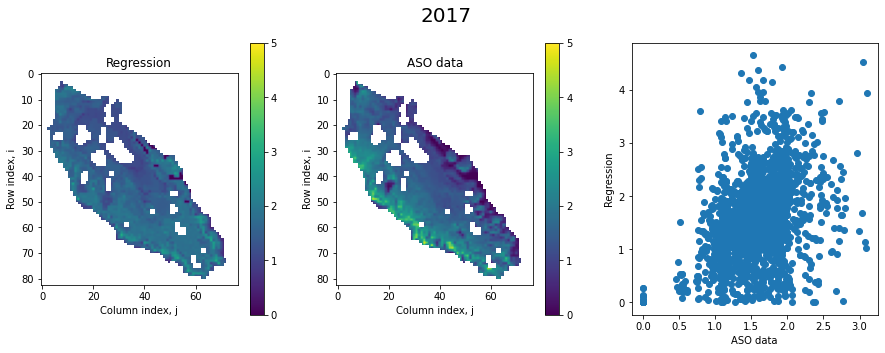

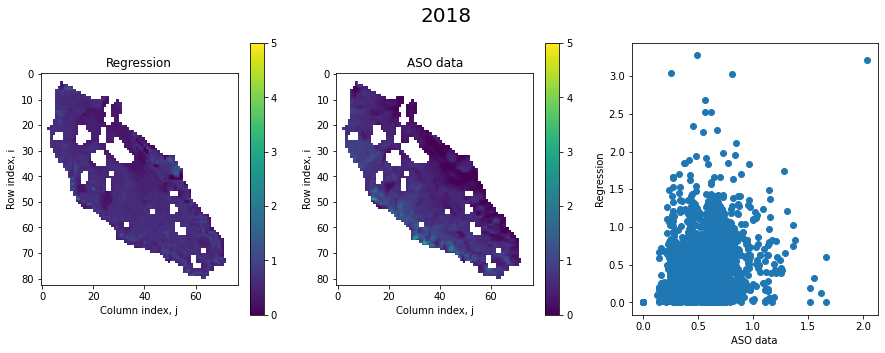

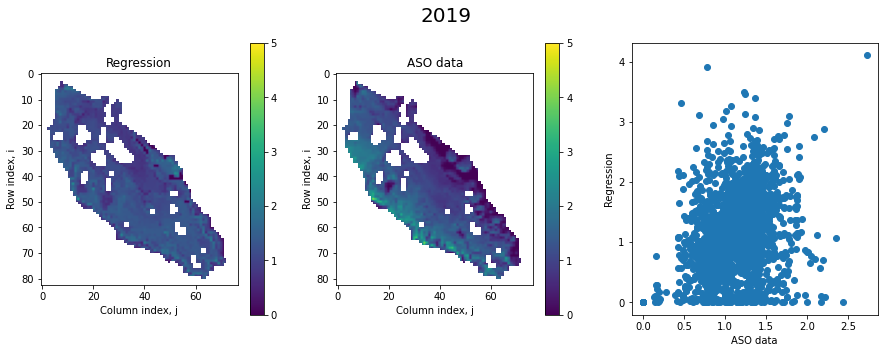

In [241]:
for f in range(F):
    year=str(int('2017')+f) 
    fig=plt.figure(figsize=(15,5))
    plt.suptitle(year,fontsize=20)
    
    D_image=np.zeros_like(D[:,:,f])
    y_pred_wz=np.zeros_like(D_clean[:,f])
    y_pred_wz[snowall]=y_pred[:,f]
    D_image[these]=y_pred_wz
    D_image[~these]=np.nan

    plt.subplot(131)
    cm1=plt.imshow(D_image)
    plt.title('Regression')
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0,5)
    plt.colorbar()

    plt.subplot(132)
    cm2=plt.imshow(D[:,:,f])
    plt.title('ASO data')
    plt.ylabel('Row index, i')
    plt.xlabel('Column index, j')
    plt.clim(0,5)
    plt.colorbar()

    plt.subplot(133)
    plt.scatter(D_image,D[:,:,f])
    plt.xlabel('ASO data')
    plt.ylabel('Regression')

    plt.show()

***f)*** Let's pretend that you are part of a very innovative startup working on highly secret machine learning algorithms. You have just shown that on average your algorithms outperform the simple station mean that is often used by water managers. You would like to report this improvement to a venture capitalist who is a potential "angel investor" in your startup. Assume that your improvement (the error reduction $\delta$) is directly equal to water saved. Use the fact that a family of 4 in California that uses 150 gallons (1 gallon = 3.78 liters) of water per day per person pays roughly $200\$$ per month in water bills to provide an upper bound for the value of your improvement in $\$$ (US dollars). [Hint: First convert from basin mean-SWE saved to water volume using the area of the $N$ points you considered, ignoring the effects of sloping terrain].

In [246]:
g2l=3.78 # 1 gallon = 3.78 litre
useprpers=150 # water use per person in gallons
fam4bill=200 # dollars

pxl_size=100*100 # meters squared
basin_area=
water_svd=-np.mean(delta)*basin_area # volume [m^3] of water saved 


-34597.48102363982

***g)*** How would you go about estimating the test error for your best configuration that you selected in ***e)***? Would you expect one of the models that you have trained to perform well in another year (why, why not)?